# 🔋 SOH Analysis for NASA Battery Dataset
This notebook computes State of Health (SOH) for batteries from two folders using discharge cycles.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the flattened dataset
file_path = "/Users/tarunshyam/Learning/NASA_Battery_data/Randomized Battery Usage/DataSet/3_Processed/flatten_fully_cleaned.csv"  # Change this to your CSV file path
df = pd.read_csv(file_path)
df.head()


,type,relative_time,voltage,current,temperature,source_file,subgroup
0,C,0.04,3.957,-2.005,22.22000,RW20.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
1,C,60.04,4.032,-2.000,22.26685,RW20.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
2,C,120.04,4.051,-2.000,22.40741,RW20.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
3,C,180.04,4.059,-2.000,22.61045,RW20.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
4,C,240.04,4.064,-2.001,22.81348,RW20.mat,RW_Skewed_High_Room_Temp_DataSet_2Post


In [3]:
# Filter only discharge data
df_discharge = df[df["type"] == "D"].copy()
print(f"Total discharge records: {len(df_discharge)}")
df_discharge.head()


Total discharge records: 45904247


,type,relative_time,voltage,current,temperature,source_file,subgroup
173,D,0.04,4.115,1.003,21.81392,RW20.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
174,D,30.04,4.086,0.999,21.86078,RW20.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
175,D,60.04,4.070,1.000,21.89202,RW20.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
176,D,90.04,4.059,1.000,21.93887,RW20.mat,RW_Skewed_High_Room_Temp_DataSet_2Post
177,D,120.04,4.051,1.000,21.98572,RW20.mat,RW_Skewed_High_Room_Temp_DataSet_2Post


In [9]:
# Detect reset in relative_time to identify new discharge cycles
def assign_cycle_id(group):
    reset_points = (group['relative_time'] < group['relative_time'].shift()).cumsum()
    group = group.copy()
    group['cycle_id'] = reset_points
    return group

# Apply this logic per battery (source_file)
df_discharge = df_discharge.groupby("source_file", group_keys=False).apply(assign_cycle_id)

# Validate
print(df_discharge[['source_file', 'relative_time', 'cycle_id']].head(20))

/var/folders/5z/w106k2293m95fljl_vr_1jhr0000gn/T/ipykernel_8187/3279597225.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_discharge = df_discharge.groupby("source_file", group_keys=False).apply(assign_cycle_id)


    source_file  relative_time  cycle_id
173    RW20.mat           0.04         0
174    RW20.mat          30.04         0
175    RW20.mat          60.04         0
176    RW20.mat          90.04         0
177    RW20.mat         120.04         0
178    RW20.mat         150.04         0
179    RW20.mat         180.04         0
180    RW20.mat         210.04         0
181    RW20.mat         240.04         0
182    RW20.mat         270.04         0
183    RW20.mat         300.04         0
184    RW20.mat         330.04         0
185    RW20.mat         360.04         0
186    RW20.mat         390.04         0
187    RW20.mat         420.04         0
188    RW20.mat         450.04         0
189    RW20.mat         480.04         0
190    RW20.mat         510.04         0
191    RW20.mat         540.04         0
192    RW20.mat         570.04         0


In [10]:
def compute_capacity(group):
    current = group["current"].values
    time = group["relative_time"].values
    if len(current) < 2:
        return np.nan
    capacity_coulombs = np.sum(current[:-1] * np.diff(time))
    return capacity_coulombs / 3600  # Convert to Ah

# Apply per battery and cycle
capacity_df = (
    df_discharge.groupby(["source_file", "cycle_id"])
    .apply(compute_capacity)
    .reset_index(name="capacity_ah")
)

capacity_df.head()


/var/folders/5z/w106k2293m95fljl_vr_1jhr0000gn/T/ipykernel_8187/1080786993.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_capacity)


,source_file,cycle_id,capacity_ah
0,RW1.mat,0,2.094995
1,RW1.mat,1,2.000353
2,RW1.mat,2,2.000239
3,RW1.mat,3,0.166638
4,RW1.mat,4,0.166641


In [ ]:
# Compute capacity in Ah for each discharge cycle
def compute_capacity(group):
    current = group["current"].values
    time = group["relative_time"].values
    if len(current) < 2:
        return np.nan
    capacity_coulombs = np.sum(current[:-1] * np.diff(time))  # I = A, Δt = s → Q = As (Coulombs)
    capacity_ah = capacity_coulombs / 3600  # Convert to Amp-hours
    return capacity_ah

# Group by source_file and cycle_id
capacity_df = (
    df_discharge.groupby(["source_file", "cycle_id"])
    .apply(compute_capacity)
    .reset_index(name="capacity_ah")
)

# Preview result
capacity_df.head()

/var/folders/5z/w106k2293m95fljl_vr_1jhr0000gn/T/ipykernel_8187/3777350229.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_capacity)


,source_file,cycle_id,capacity_ah
0,RW1.mat,0,2.094995
1,RW1.mat,1,2.000353
2,RW1.mat,2,2.000239
3,RW1.mat,3,0.166638
4,RW1.mat,4,0.166641


In [12]:
# Normalize each battery's cycle capacity to its first cycle to compute SOH (%)
capacity_df["SOH"] = capacity_df.groupby("source_file")["capacity_ah"].transform(
    lambda x: (x / x.iloc[0]) * 100
)

# Preview result
capacity_df.head()


,source_file,cycle_id,capacity_ah,SOH
0,RW1.mat,0,2.094995,100.000000
1,RW1.mat,1,2.000353,95.482471
2,RW1.mat,2,2.000239,95.477035
3,RW1.mat,3,0.166638,7.954104
4,RW1.mat,4,0.166641,7.954237


In [6]:
# Optional: Clean the x-axis subgroup if needed
capacity_df["subgroup"] = pd.to_numeric(capacity_df["subgroup"], errors="coerce")


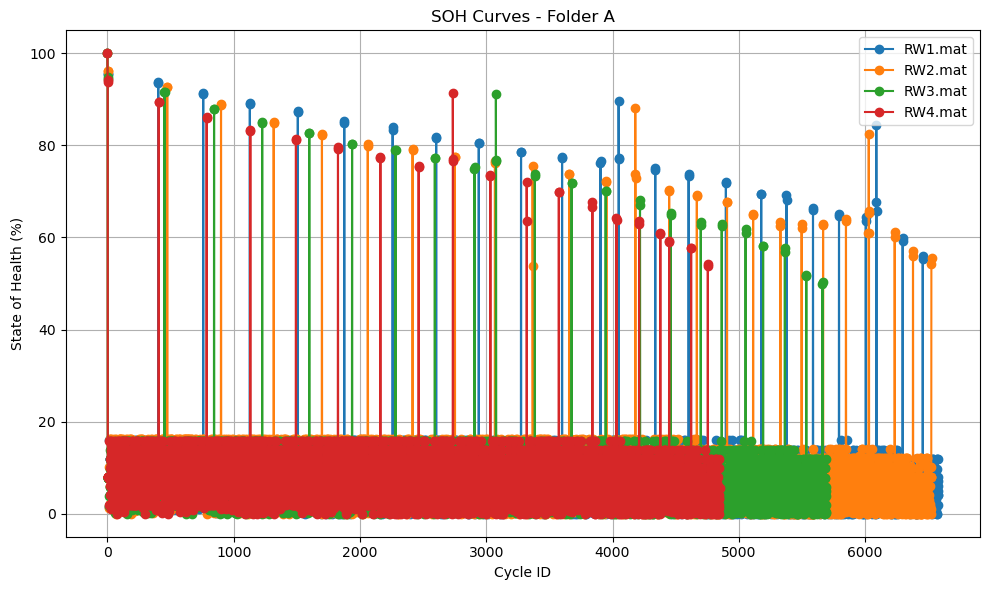

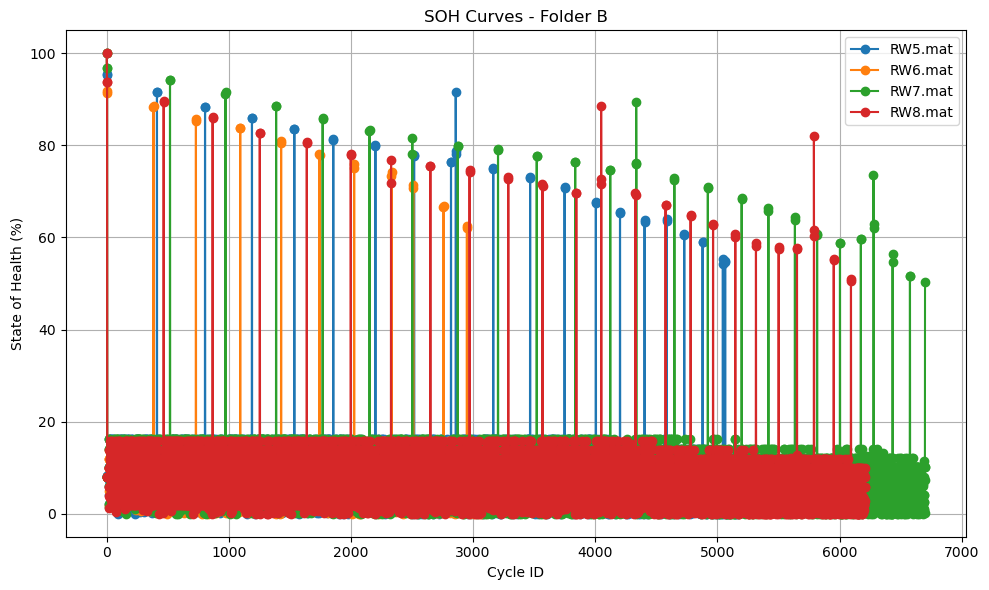

In [13]:
# Plot SOH curves by folder using cycle_id as x-axis
folder_A = ["RW1.mat", "RW2.mat", "RW3.mat", "RW4.mat"]
folder_B = ["RW5.mat", "RW6.mat", "RW7.mat", "RW8.mat"]

def plot_soh_curves(folder_batteries, title):
    plt.figure(figsize=(10, 6))
    for battery in folder_batteries:
        subset = capacity_df[capacity_df["source_file"] == battery]
        if subset.empty:
            continue  # Skip if battery data is missing
        plt.plot(subset["cycle_id"], subset["SOH"], marker='o', label=battery)
    
    plt.title(title)
    plt.xlabel("Cycle ID")
    plt.ylabel("State of Health (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot both folders
plot_soh_curves(folder_A, "SOH Curves - Folder A")
plot_soh_curves(folder_B, "SOH Curves - Folder B")


In [ ]:
# Save results to CSV
capacity_df.to_csv("soh_results.csv", index=False)
print("SOH results saved.")


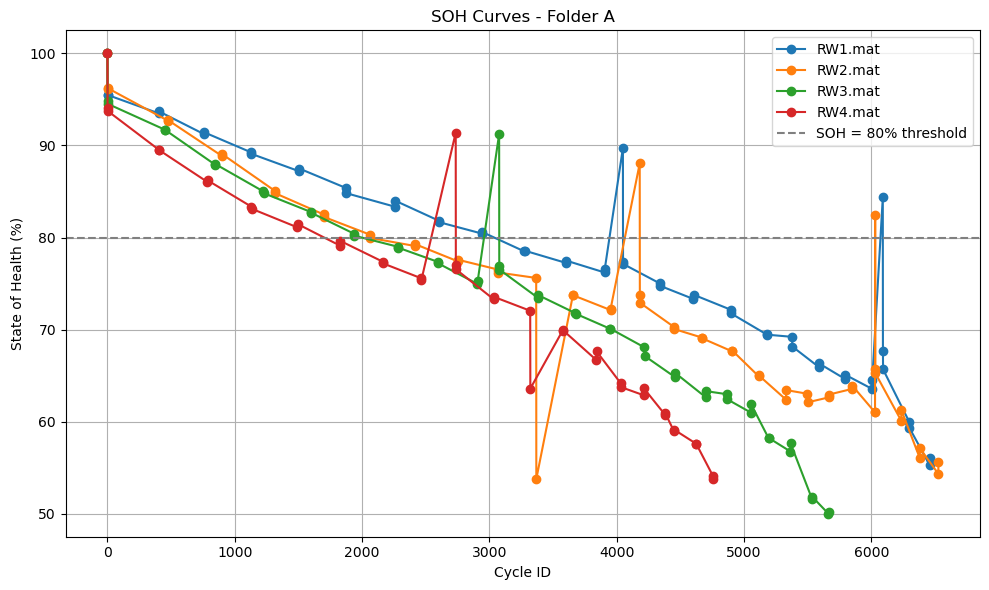

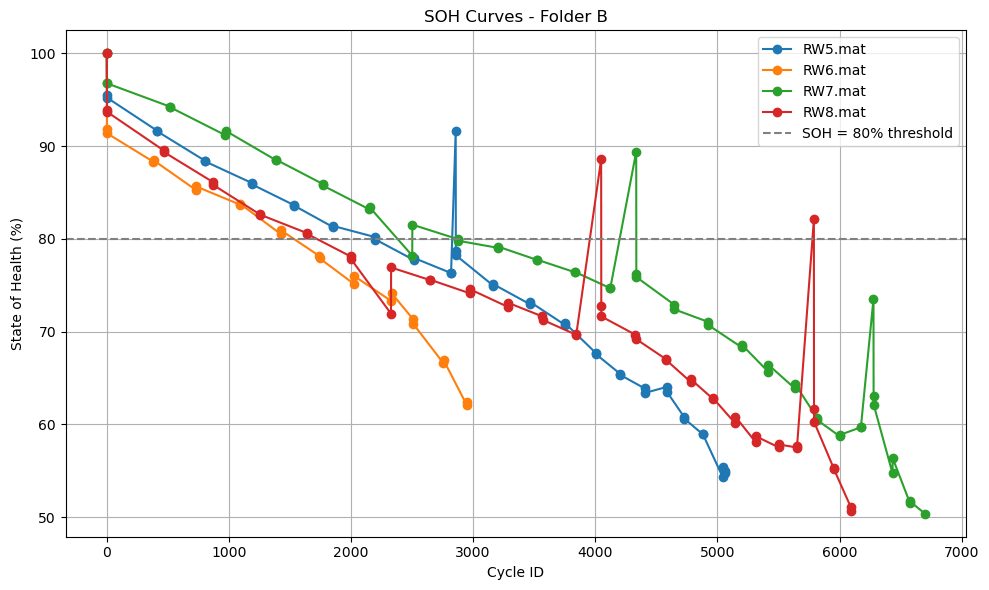

In [14]:
import matplotlib.pyplot as plt

# Plot SOH curves for a list of batteries with clean visuals
def plot_soh_curves(folder_batteries, title):
    plt.figure(figsize=(10, 6))

    for battery in folder_batteries:
        subset = capacity_df[
            (capacity_df["source_file"] == battery) &
            (capacity_df["SOH"] >= 20)  # Remove abnormal low SOH values
        ]
        if subset.empty:
            continue  # Skip if battery has no valid data
        plt.plot(subset["cycle_id"], subset["SOH"], marker='o', label=battery)

    plt.axhline(80, color='gray', linestyle='--', label='SOH = 80% threshold')  # Optional
    plt.title(title)
    plt.xlabel("Cycle ID")
    plt.ylabel("State of Health (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # Optional: Save plot to file
    # plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

# Define battery folders
folder_A = ["RW1.mat", "RW2.mat", "RW3.mat", "RW4.mat"]
folder_B = ["RW5.mat", "RW6.mat", "RW7.mat", "RW8.mat"]

# Plot both groups
plot_soh_curves(folder_A, "SOH Curves - Folder A")
plot_soh_curves(folder_B, "SOH Curves - Folder B")
